In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.linear_model import Lasso
import time
import torch.nn.functional as F
import torch

In [5]:
# import mnist data
dataset = datasets.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))

# get data and labels
data = dataset.data.numpy()
labels = dataset.targets.numpy()

# get only the data of the first 1000 images
N_samples = 10000

# flatten data
data = data.reshape(data.shape[0], -1)[:N_samples]
print(data.shape)
labels = labels[:N_samples]

# normalize data
data = data / 255

# create a matrix W of size 784 x m which can only take values of -1 or 1
m=500
W = np.random.choice([-1, 1], size=(data.shape[1], m))
W = W.astype(np.float32)
#W=torch.tensor(np.load('W_%d.npy'%m))

# create a random noise vector with mean 0 and std 1/m, and add it to the data
noise = np.random.normal(0, 1/m, (data.shape[0],m))

# compress images using W and store in Y
Y = np.dot(data, W) + noise
Y_abs = np.abs(Y) + noise

(10000, 784)


In [ ]:
#ORIGINAL APPROACH IN REPORT

# create a lasso model
lasso = Lasso(alpha=0.01,tol=0.0001,max_iter=10000)
lasso_abs=Lasso(alpha=0.01,tol=0.0001,max_iter=10000)

# fit the model, timing each one
start = time.time()
lasso.fit(Y, labels[:N_samples])
stop = time.time()

start_abs = time.time()
lasso_abs.fit(Y_abs, labels[:N_samples])
stop_abs = time.time()

# get the time taken
print('Time taken for 1st model:', stop-start)
print('Time taken for 3rd model:', stop_abs-start_abs)

# get the weights
weights = lasso.coef_
weights_abs = lasso_abs.coef_

# get the indices of the weights that are non-zero
non_zero_indices = np.where(weights != 0)[0]
non_zero_indices_abs = np.where(weights_abs != 0)[0]

# get the corresponding columns of W
W_non_zero = W[:, non_zero_indices]
W_non_zero = W_non_zero

W_non_zero_abs = W[:, non_zero_indices_abs]
W_non_zero_abs = W_non_zero_abs

# get the corresponding weights
weights_non_zero = weights[non_zero_indices]    
weights_non_zero_abs = weights_abs[non_zero_indices_abs]

# get the reconstructed data
data_reconstructed = np.dot(Y, W_non_zero.T)
data_reconstructed_2 = np.dot(Y_abs, W_non_zero.T)
data_reconstructed_abs = np.dot(Y_abs, W_non_zero_abs.T)

In [51]:
print(W_non_zero.shape)
print(data.shape)
print(Y.shape)
print(data_reconstructed.shape)


## measur_error = ||Wx - y||_2^2

def recon_error(data, data_reconstructed):
    return torch.norm(torch.tensor(data)-torch.tensor(data_reconstructed), p=2).item()

def measur_error(reconstruction, W, compressed_meas):
    return F.mse_loss(torch.tensor(np.dot(reconstruction, W)), torch.tensor(compressed_meas)).item()
print('lasso m=%d'%m)

print('recon_error')
print('1st case: ', recon_error(data, data_reconstructed)/(N_samples*784))
print('2nd case: ', recon_error(data, data_reconstructed_2)/(N_samples*784))
print('3rd case: ', recon_error(data, data_reconstructed_abs)/(N_samples*784))

print('measur_error')
print('1st case: ', measur_error(data_reconstructed, W_non_zero, Y)/N_samples)
print('2nd case: ', measur_error(data_reconstructed_2, W_non_zero, Y)/N_samples)
print('3rd case: ', measur_error(data_reconstructed_abs, W_non_zero_abs, Y_abs)/N_samples)

torch.Size([784, 200])
(1000, 784)
(1000, 200)
(1000, 784)
lasso m=200
recon_error
1st case:  41.80986196962319
2nd case:  36.97883669076724
3rd case:  36.97883669076724
measur_error
1st case:  6094957867.444199
2nd case:  3937721978.4259853
3rd case:  3929928853.246171


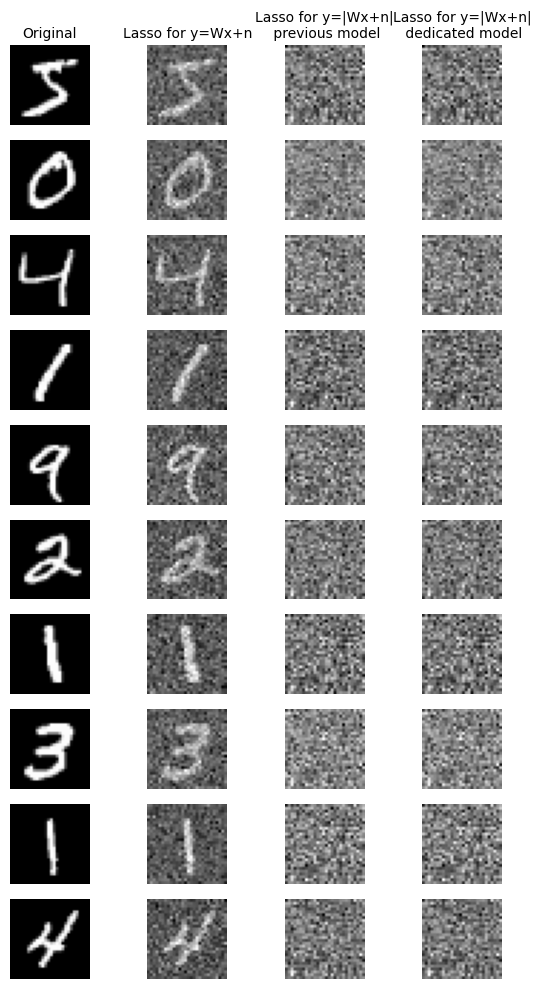

In [24]:
# plot the originals, cand the 3 cases of reconstructed data
plt.figure(figsize=(6, 10))
for i in range(10):
    plt.subplot(10, 4, i*4+1)
    plt.imshow(data[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original', fontsize=10) 
    
    plt.subplot(10, 4, i*4+2)
    plt.imshow(data_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Lasso for y=Wx+n', fontsize=10)
    
    plt.subplot(10, 4, i*4+3)
    plt.imshow(data_reconstructed_2[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Lasso for y=|Wx+n|\n previous model', fontsize=10)
    
    plt.subplot(10, 4, i*4+4)
    plt.imshow(data_reconstructed_abs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Lasso for y=|Wx+n|\n dedicated model', fontsize=10)

plt.tight_layout()
plt.savefig('lasso_reconstruction_m%d.png' % m)
plt.show()